# Spike-timing dependent plasticity

Spike-timing dependent plasticity has a number of interesting and not entirely obvious effects when we include it into the dynamics of a neural network. 

We test some of these effects in one of the simplest possible networks: one (leaky integrate-and-fire) neuron receiving input from $N$ "neurons" modelled as emitting spikes as a Poisson process (essentially at random times with a fixed firing rate). 

The synapse from the input neurons to the output neuron has conductance that decays exponentially (with time constant $\tau_e$) after each spike. 
Its efficacy changes according to a STDP rule.

We follow the treatment in the paper by Song et al. [Competitive Hebbian learning through spike-timing-dependent synaptic plasticity](https://www.nature.com/articles/nn0900_919) and we make the STDP curve asymmetric, so that the area under the curve for the "depressing" part of the curve ($\tau_{pre} - \tau_{post} > 0$) is greater then the potentiating part ($\tau_{pre} - \tau_{post} < 0$). Synapses are initialized at random values

The result will be that most synapses will be depressed at the beginning (because relative spike times are equally likely to fall in the depressing than in the potentiating part of the plasticity curve, and the depressing effect is stronger under these circumstances. (Look at Song et al. Figure 3)

Only the few synapses that are stronger, for which the input is more likely to drive the output neuron, the post-synaptic neuron will tend to follow the pre-synaptic spike and we get a potentiation. As a result, there is a partition of synapses between a group that gets very high values of conductance, and the others that will go towards zero. 

The other effect is that the neuron gets in a state in which the excitatory (synaptic) current and the leakage current are balanced, and the neuron is driven by fluctuations. 

In [3]:
from brian2 import *
import numpy as np

## setting the parameters

In [4]:
# this parameter determines the relative area-under-the-curve for depression vs potentiation in the STDP curve 
# (1 is perfect balance)
inhibition_excess = 1.05

# number of input "neurons" (random Poisson spike trains)
N = 1000

#membrane time constant for the output neuron
taum = 10*ms

# Time constants for the potentiation (pre) and depression (post) parts of the STDP curve
taupre = 20*ms
taupost = taupre

# excitatory reversal potential
Ee = 0*mV

# threshold for the integrate-and-fire neuron
vt = -54*mV

# resting potential
vr = -60*mV

# leakage reversal potential 
El = -74*mV

# synaptic time constant 
taue = 5*ms

# input mean firing rate 
F = 15*Hz

# maximal synaptic conductance 
gmax = .01

# the synaptic increment after each spike 
syn_increment = .01

dApre = None
dApsot = None


## Defining the model

In [5]:
class STDP_model:
    def __init__(self):

        global dApre, dApost
        # integrate and fire equations for the output neuron (including synaptic current decay)
        eqs_neurons = '''
        dv/dt = (ge * (Ee-vr) + El - v) / taum : volt
        dge/dt = -ge / taue : 1
        '''
        dApre = syn_increment
        dApost = -dApre * taupre / taupost * inhibition_excess
        dApost *= gmax
        dApre *= gmax
        
        
        self.net = Network()
        self.input = PoissonGroup(N, rates=F)
        self.net.add(self.input)
        self.neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                              method='exact')
        self.net.add(self.neurons)
        # equations for the synapses
        self.S = Synapses(self.input, self.neurons,
                     '''w : 1
                        dApre/dt = -Apre / taupre : 1 (event-driven)
                        dApost/dt = -Apost / taupost : 1 (event-driven)''',
                     on_pre='''ge += w
                            Apre += dApre
                            w = clip(w + Apost, 0, gmax)''',
                     on_post='''Apost += dApost
                             w = clip(w + Apre, 0, gmax)''',
                     )
        self.net.add(self.S)
        self.S.connect()

        # synapses are initialized to a random value between 0 and gmax
        self.S.w = 'rand() * gmax'
        self.mon = StateMonitor(self.S, 'w', record=[0, 1, 2, 3])
        self.net.add(self.mon)
        self.s_mon = SpikeMonitor(self.input)
        self.net.add(self.s_mon)
        
        
    def output_monitor(self):
        self.o_mon = SpikeMonitor(self.neurons)
        self.net.add(self.o_mon)
        return self.o_mon
    
    def run(self, run_time):
        self.net.run(run_time, report='text')
        

## Running the model 

These simulations will take some minutes to run (on my laptop around 3 seconds for each second of simulated time. Please be patients and grab a cup of coffee while each run executes 

### Varying the input rate 

in this simulation, we will run the network with different input firing rates, from 10 to 40 Hz. We will reproduce the result from the Song et al. paper, Figure 2a-c. (Ignore the warnings if you get any)

In [6]:
out_rates = []
w_matrices = []
firing_rates = np.arange(10, 41, 5)
for F in [f*Hz for f in firing_rates]:
    # if we want to change some of the parameters from the default values, we have to do it here below
    inhibition_excess = 1.05
    
    model = STDP_model()
    
    model.S.w = 'rand() * gmax'
    o_mon = model.output_monitor()
    model.run(100*second)
    device.build(directory='STDP_standalone', compile=True, run=True, debug=False)
    out_rates.append(o_mon.count[0])
    w_matrices.append(model.S.w[:])

out_rates = np.array(out_rates)

Starting simulation at t=0. s for a duration of 100. s
13.9626 s (13%) simulated in 10s, estimated 1m 2s remaining.
27.7947 s (27%) simulated in 20s, estimated 52s remaining.
40.6913 s (40%) simulated in 30s, estimated 44s remaining.
53.8913 s (53%) simulated in 40s, estimated 34s remaining.
67.6181 s (67%) simulated in 50s, estimated 24s remaining.
81.373 s (81%) simulated in 1m 0s, estimated 14s remaining.
95.4953 s (95%) simulated in 1m 10s, estimated 3s remaining.
100. s (100%) simulated in 1m 13s
Starting simulation at t=0. s for a duration of 100. s
12.9416 s (12%) simulated in 10s, estimated 1m 7s remaining.
25.7823 s (25%) simulated in 20s, estimated 58s remaining.
39.1986 s (39%) simulated in 30s, estimated 47s remaining.
52.7541 s (52%) simulated in 40s, estimated 36s remaining.
65.6971 s (65%) simulated in 50s, estimated 26s remaining.
78.5448 s (78%) simulated in 1m 0s, estimated 16s remaining.
92.1106 s (92%) simulated in 1m 10s, estimated 6s remaining.
100. s (100%) simul

let's plot the output firing rate as a function of the input firing rate. Similar to Song et al. (Figure 2c) the output activity increases only weakly when the firing rate increases (note that the plot is not exactly the same as in the paper, because the model parameters are slightly different, so that we can see the main effects in shorter simulations) 

Text(0, 0.5, 'Output firing rate (Hz)')

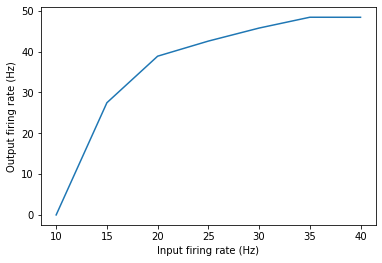

In [7]:
plot(firing_rates, out_rates/100)
xlabel("Input firing rate (Hz)")
ylabel("Output firing rate (Hz)")

Now let's look at the distribution of the synaptic weights, for each of the runs (change run_no to look at the result for different firing rates)

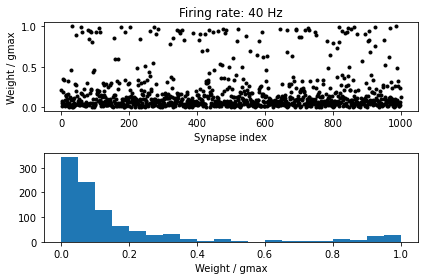

In [17]:
run_no = 6

subplot(211)
title("Firing rate: " + str(firing_rates[run_no]) + " Hz")
plot(w_matrices[run_no] / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(212)
hist(w_matrices[run_no] / gmax, 20)
xlabel('Weight / gmax')

tight_layout()
show()